In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy

In [25]:
df = pd.read_csv('simpsons_dataset.csv')
df.shape

(158314, 2)

In [26]:
df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [27]:
df.isnull().sum()

raw_character_text    17814
spoken_words          26459
dtype: int64

In [28]:
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

raw_character_text    0
spoken_words          0
dtype: int64

In [29]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 3.1 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [30]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
	# Lemmatizes and removes stopwords
	# doc needs to be a spacy Doc object
	txt = [token.lemma_ for token in doc if not token.is_stop]
	# Word2Vec uses context words to learn the vector representation of a target word,
	# if a sentence is only one or two words long,
	# the benefit for the training is very small
	if len(txt) > 2:
		return ' '.join(txt)

In [31]:
import re
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words'])

In [32]:
from time import *
t = time()
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning,batch_size=5000, n_process=-1)] # TODO: Fix the error
print('Time to clean up everything: {} mins'.format(round((time() - t)/ 60, 2)))

Time to clean up everything: 0.74 mins


In [33]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(85955, 1)

In [36]:
from gensim.models.phrases import Phrases, Phraser

In [37]:
sent = [row.split() for row in df_clean['clean']]

In [38]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

In [39]:
bigram = Phraser(phrases)

In [40]:
sentences = bigram[sent]

In [42]:
from collections import defaultdict

In [44]:
word_freq = defaultdict(int)
for sent in sentences:
	for i in sent:
		word_freq[i] += 1
len(word_freq)

29694

In [45]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['oh', 'like', 'know', 'get', 'hey', 'think', 'come', 'right', 'look', 'want']

In [46]:
import multiprocessing
from gensim.models import Word2Vec

In [47]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [49]:
w2v_model = Word2Vec(min_count=20,
					window=2,
					vector_size=300, # TODO: Fix the error
					sample=6e-5,
					alpha=0.03,
					min_alpha=0.0007,
					negative=20,
					workers=cores-1)

In [50]:
t = time()
w2v_model.build_vocab(sentences, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60,2)))

Time to build vocab: 0.01 mins


In [51]:
t = time()
w2v_model.train(sentences, total_examples=w2v_model.corpus_count,epochs=30, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - t) /60, 2)))

Time to train the model: 0.26 mins


In [52]:
w2v_model.init_sims(replace=True)

/var/folders/33/fpkrjvyx2xjbfj5j99fyh82c0000gn/T/ipykernel_54305/514372312.py:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


In [53]:
w2v_model.wv.most_similar(positive=["homer"])

[('marge', 0.7333310842514038),
 ('depressed', 0.7118172645568848),
 ('bongo', 0.6799899935722351),
 ('gee', 0.6794356107711792),
 ('humiliate', 0.6661452651023865),
 ('shoulda', 0.6586787700653076),
 ('sweetheart', 0.6534411907196045),
 ('terrific', 0.6508785486221313),
 ('attract', 0.649687647819519),
 ('straighten', 0.6484372019767761)]

In [54]:
w2v_model.wv.most_similar(positive=["homer_simpson"])

[('congratulation', 0.6964143514633179),
 ('robert', 0.6865057945251465),
 ('select', 0.6700775027275085),
 ('honor', 0.667482852935791),
 ('fellow', 0.6598320007324219),
 ('recent', 0.6586741805076599),
 ('committee', 0.6568673253059387),
 ('united_states', 0.6565409302711487),
 ('aboard', 0.6555672287940979),
 ('council', 0.6526107788085938)]

In [55]:
w2v_model.wv.most_similar(positive=["marge"])

[('homer', 0.7333311438560486),
 ('homie', 0.6899690628051758),
 ('darling', 0.6748515963554382),
 ('humiliate', 0.6747962236404419),
 ('grownup', 0.6699056625366211),
 ('ned', 0.6694926023483276),
 ('depressed', 0.6662446856498718),
 ('affair', 0.663642406463623),
 ('sweetheart', 0.663358211517334),
 ('want', 0.6628985404968262)]

In [56]:
w2v_model.wv.most_similar(positive=["bart"])

[('lisa', 0.7963614463806152),
 ('pay_attention', 0.7639678716659546),
 ('hearing', 0.7573943138122559),
 ('mom', 0.7389968037605286),
 ('convince', 0.7260046005249023),
 ('strangle', 0.7253894805908203),
 ('homework', 0.7226669192314148),
 ('creepy', 0.7209768295288086),
 ('mom_dad', 0.7164660692214966),
 ('jealous', 0.700567901134491)]

In [57]:
w2v_model.wv.similarity('maggie', 'baby')

0.6484889

In [63]:
nn_sim_list = ['maggie','baby', 'bart', 'nelson','tavern']
sim_matrix = [ [ ] for i in range(len(nn_sim_list))]
print(sim_matrix)
for index, word in enumerate(nn_sim_list):
	for i in range(len(nn_sim_list)):
		sim_matrix[index].append(w2v_model.wv.similarity(word, nn_sim_list[i]))

[[], [], [], [], []]


In [64]:
sim_matrix

[[1.0, 0.6484889, 0.667657, 0.34423727, 0.3217548],
 [0.6484889, 1.0, 0.40625465, 0.29139838, 0.25681216],
 [0.667657, 0.40625465, 1.0, 0.5785908, 0.14173926],
 [0.34423727, 0.29139838, 0.5785908, 1.0, 0.07590412],
 [0.3217548, 0.25681216, 0.14173926, 0.07590412, 0.99999994]]

In [65]:
w2v_model.wv.doesnt_match(["nelson", "bart", "milhouse"])

'nelson'

In [66]:
w2v_model.wv.most_similar(positive=["woman", "homer"],negative=["marge"], topn=3)

[('man', 0.591317892074585),
 ('wealthy', 0.559773862361908),
 ('pronounce', 0.5467578172683716)]

# Exercise

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style


In [68]:
class Settings():
	def __init__(self):
		# Hyper Parameter
		self.m = 3
		self.d = 10
		self.a = 0.01
		self.epoch = 100
		self.xmax = 1
		self.f_a = 0.75

In [206]:
class Data():
	def __init__(self, settings):
		self.m = settings.m
		self.make_corpus()
		self.co_occurrence_matrix()
	def make_corpus(self):
		text = "i love doing this project it is the thing which i enjoythe most"
		corpus = [[word.lower() for word in text.split()]]
		self.corpus = corpus
	def preparation(self):
		""" Making the frequency matrix"""
		self.word_freq = defaultdict(int)
		for sentence in self.corpus:
			for word in sentence:
				self.word_freq[word] += 1
		# TODO: Implement the logic for word_freq
		# self.words decide the index of all the words
		self.words = list(self.word_freq.keys())
		self.T = len(self.words)
		# word_index will give index for a given word and vice versa for index_word
		self.word_index = dict([(word, i) for i, word in enumerate(self.words)])
		self.index_word = dict([(i, word) for i, word in enumerate(self.words)])
		# print(self.word_index)

	def co_occurrence_matrix(self):
		self.preparation()
		# In X each word have a particular row and column according to their index.
		# Xij - tabulate number of times word j appear in the context of word i
		self.X = np.zeros((self.T, self.T))
		for sentence in self.corpus:
			sen_len = len(sentence)
			for i, c_word in enumerate(sentence):
				# target is the center word index
				# context is the context word index
				target = self.word_index[c_word]
				for j in range(i - self.m, i + self.m + 1):
					if j != i and 0 <= j and j < sen_len:
						context_word = sentence[j]
						context = self.word_index[context_word]
						# print(target, context)
						self.X[target, context] += 1

In [207]:
class Model():
	def __init__(self, data, settings):
		self.settings = settings
		self.data = data
		self.X = self.data.X
		self.epoch = self.settings.epoch
		self.fun = np.vectorize(self.f)
		self.prepare()
		self.plot_initialise()
		
		# TODO: Appropriate additions, if any
	def train(self):
		self.prepare()
		i_list = []
		j_list = []
		# Iterating through the entire dataset epoch number of times
		# TODO: Replace ... with the epoch taken from settings
		# print(self.U.shape)
		# print(self.V.shape)
		for i in range(0, self.epoch):
			delta = self.fun(self.X) * (self.U @ self.V -np.log(self.X))
			np.nan_to_num(delta, copy=False)
			U_grad = delta @ self.V.T
			V_grad = self.U.T @ delta
			# print(U_grad, V_grad)
			U_grad[:, self.settings.d+1] = 0
			V_grad[self.settings.d+1, :] = 0
			# Updating U and V
			self.U = self.U - self.settings.a * U_grad
			self.V = self.V - self.settings.a * V_grad
			# Plotting Loss
			i_list.append(i)
			self.update_loss()
			j_list.append(self.J)
		self.plot(i_list, j_list)

	def prepare(self):
		self.U = np.random.uniform(-1, 1, (self.data.T, self.settings.d+ 2))
		self.V = np.random.uniform(-1, 1, (self.settings.d + 2, self.data.T))
		for i in range(0, self.data.T):
			self.U[self.settings.d + 1, i] = 1
			self.V[i, self.settings.d + 1] = 1
	def f(self, x):
		if x > self.settings.xmax:
			return 1
		else:
			y = (x/self.settings.xmax)**self.settings.f_a
			return y

	def update_loss(self):
		J = self.fun(self.X) * ((self.U @ self.V - np.log(self.X))**2)
		np.nan_to_num(J, copy=False)
		self.J = J.sum() / 2
  
	def plot(self, i_list, j_list): # TODO Update the function to get one graph
		# s - Marker size
		# get only one graph
		plt.scatter(i_list, j_list, color = 'red', s = 3)
		plt.show(block=True)
		plt.pause(0.001)
	def plot_initialise(self):
		style.use('dark_background')
		plt.figure()
		plt.xlabel('Number of iterations')
		plt.ylabel('Loss')
	def predict(self, word):
		index = self.data.word_index[word]
		w = self.U[index, :] + self.V[:, index].T
		return w[1:-1] / 2

/var/folders/33/fpkrjvyx2xjbfj5j99fyh82c0000gn/T/ipykernel_54305/436796567.py:21: RuntimeWarning: divide by zero encountered in log
  delta = self.fun(self.X) * (self.U @ self.V -np.log(self.X))
/var/folders/33/fpkrjvyx2xjbfj5j99fyh82c0000gn/T/ipykernel_54305/436796567.py:21: RuntimeWarning: invalid value encountered in multiply
  delta = self.fun(self.X) * (self.U @ self.V -np.log(self.X))
/var/folders/33/fpkrjvyx2xjbfj5j99fyh82c0000gn/T/ipykernel_54305/436796567.py:51: RuntimeWarning: divide by zero encountered in log
  J = self.fun(self.X) * ((self.U @ self.V - np.log(self.X))**2)
/var/folders/33/fpkrjvyx2xjbfj5j99fyh82c0000gn/T/ipykernel_54305/436796567.py:51: RuntimeWarning: invalid value encountered in multiply
  J = self.fun(self.X) * ((self.U @ self.V - np.log(self.X))**2)


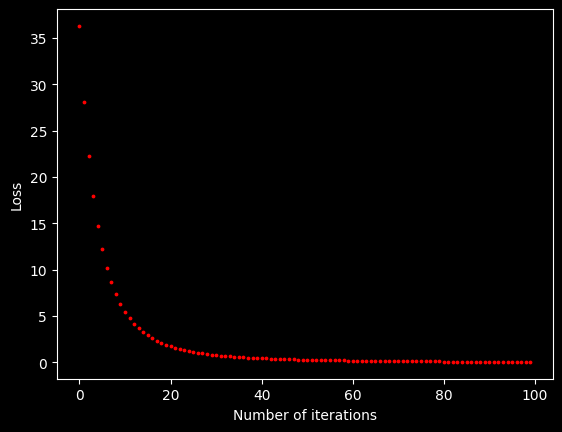

In [208]:
""" Conventions
m - Window size
d - Dimension of vectors
a - Learning rate
U - Matrix for hidden layer calculation
V - Matrix for output calculation
X - Co-occurrence matrix
T - Total number of unique words
J - Loss
u - target vector
v - context vector
"""
settings = Settings()
data = Data(settings)
model = Model(data, settings)
model.train()

In [211]:
word = input('Enter the word whose vector you want to see.\n')
print(model.predict(word))

[ 0.37907879  0.1213013  -0.40904317  0.5535099   0.19163475  0.09363237
  0.44902098 -0.45160378 -0.17646849 -0.79363215]
